In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import os

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu' 

In [3]:
!nvidia-smi

Sat Oct 30 23:46:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   34C    P0    63W / 300W |     10MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   44C    P0   154W / 300W |  32473MiB / 32480MiB |     26%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding =4), #cifar 10 image size : 32x32
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root = './data', train=True, 
                download= True, transform = transform_train)
test_dataset = torchvision.datasets.CIFAR10(root = './data', train = False,
                download=True, transform= transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=96,
                                          shuffle = True, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=96,
                                         shuffle =True, num_workers =2)

#num_workers =2 인지 4인지 or batch_size test의 경우는 왜 100인지?

Files already downloaded and verified
Files already downloaded and verified


In [5]:
'''MobileNetV2 in PyTorch.
See the paper "Inverted Residuals and Linear Bottlenecks:
Mobile Networks for Classification, Detection and Segmentation" for more details.
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride==1 else out
        return out


class MobileNetV2(nn.Module):
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 1),
           (6,  24, 2, 1),  # NOTE: change stride 2 -> 1 for CIFAR10
           (6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1),
           (6, 160, 3, 2),
           (6, 320, 1, 1)]

    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        # NOTE: change conv1 stride 2 -> 1 for CIFAR10
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.linear = nn.Linear(1280, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.relu(self.bn2(self.conv2(out)))
        # NOTE: change pooling kernel_size 7 -> 4 for CIFAR10
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def test():
    net = MobileNetV2()
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

# test()

In [6]:
net = MobileNetV2()
net = net.to(device)

if device == 'cuda:2':
#     net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [12]:
# net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.045
file_name = 'resnet18_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.00004)

loss_list = []
accuracy_list=[]

def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)#예측값과 실제 타깃값
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())

    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        
    accuracy_list.append(100. * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    loss_list.append(loss)
    print('Test average loss:', loss / total)    

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')


        
#learning rate를 바꾸기
def adjust_learning_rate(optimizer, epoch):
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        if epoch <=200 and epoch != 0:
            param_group['lr'] = lr * 0.98
        print(param_group['lr'])

In [13]:
for epoch in range(0, 150):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)

0.045

[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.96875
Current benign train loss: 0.12181440740823746

Current batch: 100
Current benign train accuracy: 0.9270833333333334
Current benign train loss: 0.16026674211025238

Current batch: 200
Current benign train accuracy: 0.9375
Current benign train loss: 0.20729242265224457

Current batch: 300
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.09199470281600952

Current batch: 400
Current benign train accuracy: 0.9270833333333334
Current benign train loss: 0.19292093813419342

Current batch: 500
Current benign train accuracy: 0.9375
Current benign train loss: 0.13697528839111328

Total benign train accuarcy: 94.074
Total benign train loss: 85.43001103401184

[ Test epoch: 0 ]

Test accuarcy: 88.76
Test average loss: 0.004110706500709057
Model Saved!
0.0441

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.9375
Current benign train loss: 0.15310746431350708

Curr


Current batch: 300
Current benign train accuracy: 0.96875
Current benign train loss: 0.10700217634439468

Current batch: 400
Current benign train accuracy: 0.96875
Current benign train loss: 0.10580110549926758

Current batch: 500
Current benign train accuracy: 0.9270833333333334
Current benign train loss: 0.20154203474521637

Total benign train accuarcy: 96.184
Total benign train loss: 56.28060010261834

[ Test epoch: 9 ]

Test accuarcy: 90.47
Test average loss: 0.0036819783177226783
Model Saved!
0.036768276309939604

[ Train epoch: 10 ]

Current batch: 0
Current benign train accuracy: 0.96875
Current benign train loss: 0.06543894112110138

Current batch: 100
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.03400811925530434

Current batch: 200
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.1204095408320427

Current batch: 300
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.08708876371383667



Current batch: 500
Current benign train accuracy: 0.96875
Current benign train loss: 0.09180846810340881

Total benign train accuarcy: 97.416
Total benign train loss: 36.982431260403246

[ Test epoch: 18 ]

Test accuarcy: 91.44
Test average loss: 0.0037514359042048456
Model Saved!
0.030655468090795137

[ Train epoch: 19 ]

Current batch: 0
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.09743189066648483

Current batch: 100
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.030450664460659027

Current batch: 200
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.039341866970062256

Current batch: 300
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.04920513927936554

Current batch: 400
Current benign train accuracy: 0.9479166666666666
Current benign train loss: 0.15110887587070465

Current batch: 500
Current benign train accuracy: 0.96875
Current benign train loss: 0.08


Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.013641554862260818

Current batch: 100
Current benign train accuracy: 0.96875
Current benign train loss: 0.05484873056411743

Current batch: 200
Current benign train accuracy: 0.9583333333333334
Current benign train loss: 0.09528184682130814

Current batch: 300
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.05191151797771454

Current batch: 400
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.0760631188750267

Current batch: 500
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.09608709067106247

Total benign train accuarcy: 98.45
Total benign train loss: 22.706815694924444

[ Test epoch: 28 ]

Test accuarcy: 91.06
Test average loss: 0.004249825502187014
Model Saved!
0.025047749359397607

[ Train epoch: 29 ]

Current batch: 0
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.047656770795


Current batch: 200
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.025857364758849144

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.016517160460352898

Current batch: 400
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.04058303311467171

Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.012887123972177505

Total benign train accuarcy: 98.96
Total benign train loss: 15.096883516642265

[ Test epoch: 37 ]

Test accuarcy: 92.08
Test average loss: 0.00390546750202775
Model Saved!
0.020883504974794645

[ Train epoch: 38 ]

Current batch: 0
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.02714863419532776

Current batch: 100
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.02835533767938614

Current batch: 200
Current benign train accuracy: 0.9895833333333334
Current benign train loss:


Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.06475571542978287

Total benign train accuarcy: 99.364
Total benign train loss: 10.044435775489546

[ Test epoch: 46 ]

Test accuarcy: 92.18
Test average loss: 0.004003754096478224
Model Saved!
0.017411575538168883

[ Train epoch: 47 ]

Current batch: 0
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.05499648675322533

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0020986783783882856

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.003832103917375207

Current batch: 300
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.026113025844097137

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.008796031586825848

Current batch: 500
Current benign train accuracy: 0.9791666666666666
Current benign train loss: 0.04619499668478966

Tota


Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.004525338765233755

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0013000813778489828

Current batch: 300
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.022944509983062744

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.007262818980962038

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.013196165673434734

Total benign train accuarcy: 99.666
Total benign train loss: 5.19800885670702

[ Test epoch: 56 ]

Test accuarcy: 92.46
Test average loss: 0.004225151510909199
Model Saved!
0.014226524897306202

[ Train epoch: 57 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.004023184534162283

Current batch: 100
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.01739252172410488

Current batch: 200
Current benign 


Total benign train accuarcy: 99.756
Total benign train loss: 4.04239557654364

[ Test epoch: 65 ]

Test accuarcy: 92.97
Test average loss: 0.003992071582376957
Model Saved!
0.011861333296017903

[ Train epoch: 66 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0021968751680105925

Current batch: 100
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.025478936731815338

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0011532088974490762

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0025840681046247482

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.013956948183476925

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0056444257497787476

Total benign train accuarcy: 99.816
Total benign train loss: 3.293106449265906

[ Test epoch: 66 ]

Test accuarcy: 92.72
Test average loss: 0.004083


Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0011066625593230128

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.00027491964283399284

Total benign train accuarcy: 99.878
Total benign train loss: 2.2344528723733674

[ Test epoch: 75 ]

Test accuarcy: 92.86
Test average loss: 0.004052780837193131
Model Saved!
0.009691572889606063

[ Train epoch: 76 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0009365772712044418

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.001915140077471733

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0018106860807165504

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0001206968809128739

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.001051499741151929

Current batch: 500
Current benign train accuracy: 1.0
Cu


Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0001415417791577056

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0038750178646296263

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.00012116798461647704

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0023940876126289368

Total benign train accuarcy: 99.926
Total benign train loss: 1.5393921275026514

[ Test epoch: 85 ]

Test accuarcy: 93.11
Test average loss: 0.004107859111018479
Model Saved!
0.007918720664065676

[ Train epoch: 86 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0036062358412891626

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.002398018492385745

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.000587361166253686

Current batch: 300
Current benign train accuracy: 1.0
Cu


Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0011285030050203204

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0003532063274178654

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.001992835896089673

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0006059693987481296

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0016757580451667309

Current batch: 500
Current benign train accuracy: 0.9895833333333334
Current benign train loss: 0.013690323568880558

Total benign train accuarcy: 99.972
Total benign train loss: 0.827881206292659

[ Test epoch: 95 ]

Test accuarcy: 93.2
Test average loss: 0.0040220388450892645
Model Saved!
0.00647017131994656

[ Train epoch: 96 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.00029844578239135444

Current batch: 100
Current benign train accur


Total benign train accuarcy: 99.968
Total benign train loss: 0.7653265863255001

[ Test epoch: 104 ]

Test accuarcy: 92.96
Test average loss: 0.00405866172797978
Model Saved!
0.005394490858604121

[ Train epoch: 105 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0016431808471679688

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.00017934235802385956

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 9.86360537353903e-05

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0006573752034455538

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0029055923223495483

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.00030045249150134623

Total benign train accuarcy: 99.97
Total benign train loss: 0.6744416667133919

[ Test epoch: 105 ]

Test accuarcy: 93.06
Test average loss: 0.00421826818138


Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.00013078188931103796

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.000756399764213711

Total benign train accuarcy: 99.97
Total benign train loss: 0.6241519628620154

[ Test epoch: 114 ]

Test accuarcy: 93.19
Test average loss: 0.004087209567427635
Model Saved!
0.004407691787568881

[ Train epoch: 115 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.00011562591680558398

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 7.25480931578204e-05

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0018356508808210492

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0007788295042701066

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.00012789775792043656

Current batch: 500
Current benign train accuracy: 1.0


Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0007805692148394883

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0005533341900445521

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 8.468994201393798e-05

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.00025035563157871366

Total benign train accuarcy: 99.972
Total benign train loss: 0.6026331834600569

[ Test epoch: 124 ]

Test accuarcy: 93.0
Test average loss: 0.0041449201576411725
Model Saved!
0.003601405100764094

[ Train epoch: 125 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 9.617264004191384e-05

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0008926595910452306

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0001824076025513932

Current batch: 300
Current benign train accuracy: 1.


Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.002512498525902629

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0002670255780685693

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 4.185804209555499e-05

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0057728830724954605

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0002948449400719255

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.0002815220213960856

Total benign train accuarcy: 99.986
Total benign train loss: 0.4543916994098254

[ Test epoch: 134 ]

Test accuarcy: 93.13
Test average loss: 0.0040367754402755055
Model Saved!
0.0029426101744204464

[ Train epoch: 135 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0001553110923850909

Current batch: 100
Current benign train accuracy: 1.0



Total benign train accuarcy: 99.998
Total benign train loss: 0.31727679089453886

[ Test epoch: 143 ]

Test accuarcy: 93.37
Test average loss: 0.004068326129950583
Model Saved!
0.0024533946477444573

[ Train epoch: 144 ]

Current batch: 0
Current benign train accuracy: 1.0
Current benign train loss: 0.0004365095228422433

Current batch: 100
Current benign train accuracy: 1.0
Current benign train loss: 0.0002512200444471091

Current batch: 200
Current benign train accuracy: 1.0
Current benign train loss: 0.0004950076690874994

Current batch: 300
Current benign train accuracy: 1.0
Current benign train loss: 0.0002525474119465798

Current batch: 400
Current benign train accuracy: 1.0
Current benign train loss: 0.0002146669285139069

Current batch: 500
Current benign train accuracy: 1.0
Current benign train loss: 0.00016647989104967564

Total benign train accuarcy: 99.986
Total benign train loss: 0.42196770794907934

[ Test epoch: 144 ]

Test accuarcy: 93.08
Test average loss: 0.004062726

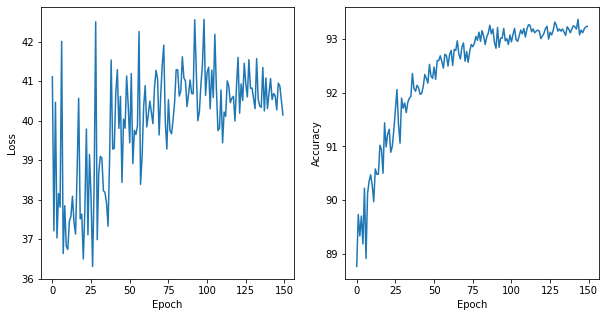

In [14]:
epochs = np.arange(0,150)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1) 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.plot(epochs,loss_list) 
plt.subplot(1,2,2) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.plot(epochs, accuracy_list) 
plt.show()